# 第一部分 数据生成

In [144]:
import numpy as np
import matplotlib.pyplot as plt

# np.random.seed(0)

# 生成指定个数的数据
def generate_data(nums):
    x = np.random.uniform(-5, 5, nums)  # [-5, 5]生成随机样本点
    y = np.sin(x) + np.random.normal(0, 0.5, nums)  # sin函数值+方差为0.5的高斯噪声
    return x, y

# 三个不同大小的数据集
x_s, y_s = generate_data(10)  # S（10个样本）
x_m, y_m = generate_data(30)  # M（30个样本）
x_l, y_l = generate_data(60)  # L（60个样本）

# 数据的真实曲线
x_true = np.linspace(-5, 5)  # 用于绘制真实的sin函数曲线
y_true = np.sin(x_true)


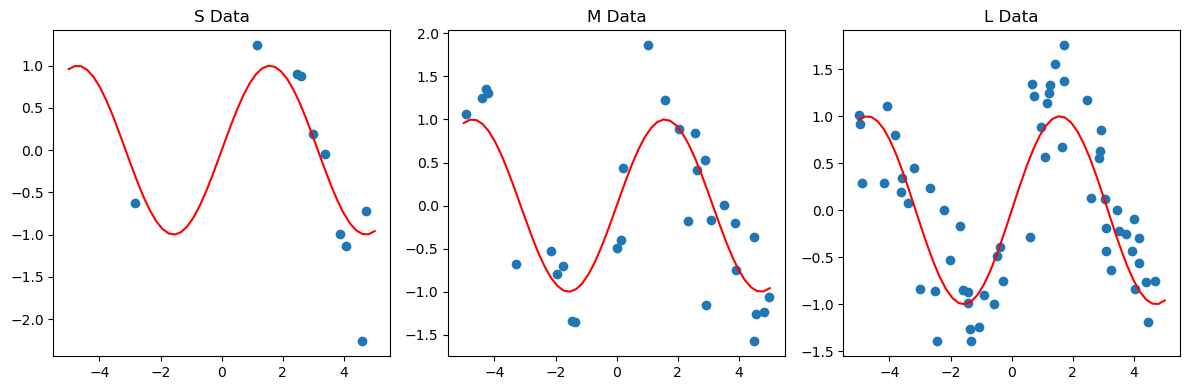

In [150]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(x_s, y_s)
plt.plot(x_true, y_true, 'red')
plt.title("S Data")

plt.subplot(132)
plt.scatter(x_m, y_m)
plt.plot(x_true, y_true, 'red')
plt.title("M Data")

plt.subplot(133)
plt.scatter(x_l, y_l)
plt.plot(x_true, y_true, 'red')
plt.title("L Data")


plt.tight_layout()
plt.show()

# 第二部分 极大似然估计

用K=2, K=4, K=8 的模型，分别用极大似然原理拟合S, M, L三个数据集。

In [151]:
# 多项式线性函数
def Polynomial_function(params, x):
    # p：多项式系数列表、x：输入样本
    y_pred = np.polyval(params, x)
    
    return y_pred

# 对于一个样本x，获取设计矩阵的一个维度（行向量）
def poly_vector(degree, x):
    if degree == 2:
        vector = np.array([1,x])
    elif degree == 4:
        vector = np.array([1,x,pow(x,2),pow(x,3)])
    elif degree == 8:
        vector =  np.array([1,x,pow(x,2),pow(x,3),pow(x,4),pow(x,5),pow(x,6),pow(x,7)])

    return vector

# 根据求得的w，求出预测拟合函数
def pre_f(degree, w):
    x= np.linspace(-5,5)
    
    if degree == 2:
        y = w[0] + w[1]*x
    elif degree == 4:
        y = w[0] + w[1]*x + w[2]*x**2 + w[3]*x**3
    elif degree == 8:
        y = w[0] + w[1]*x + w[2]*x**2 + w[3]*x**3 + w[4]*x**4 + w[5]*x**5 + w[6]*x**6 + w[7]*x**7

    return y


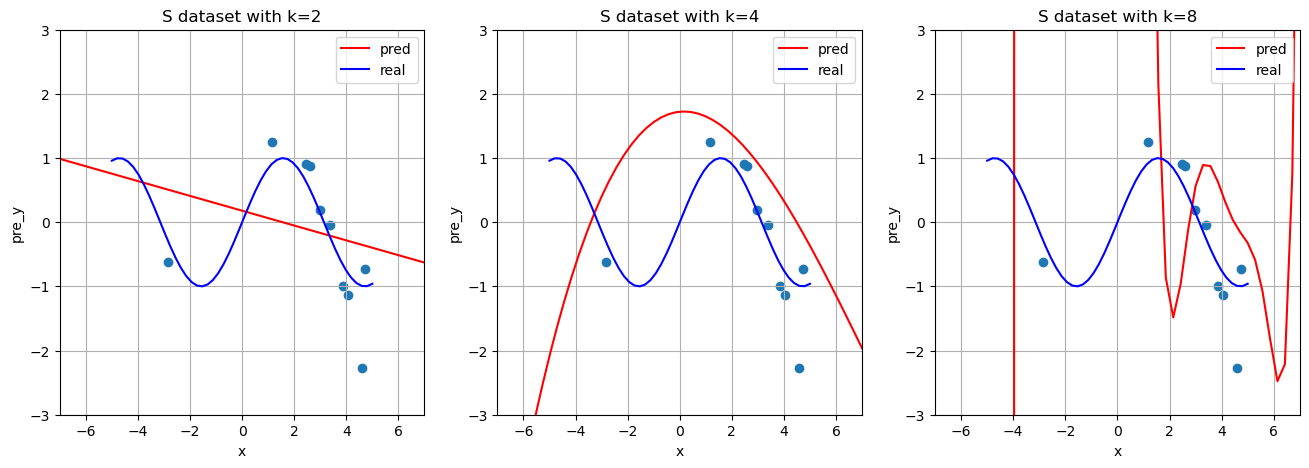

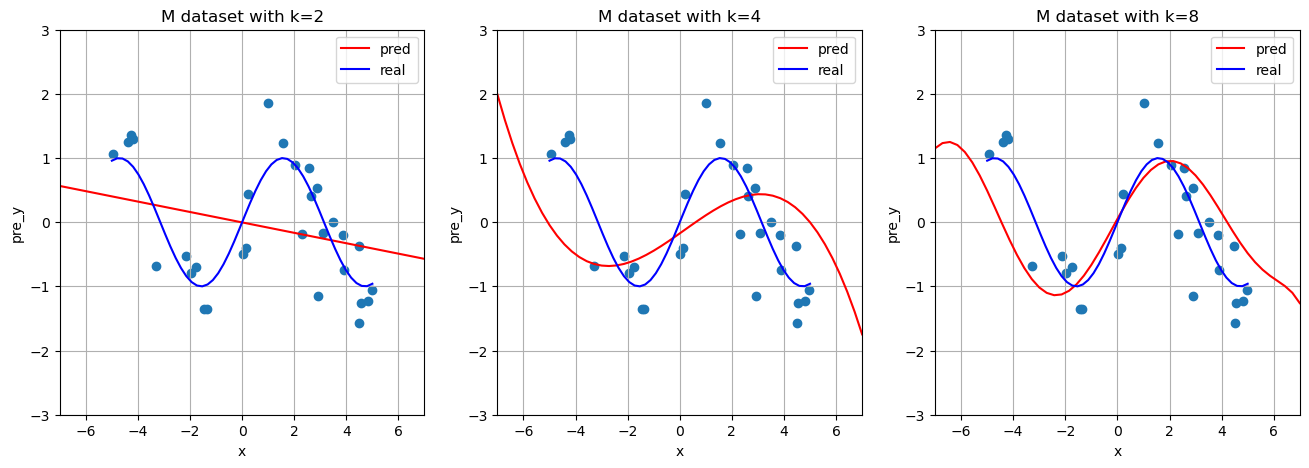

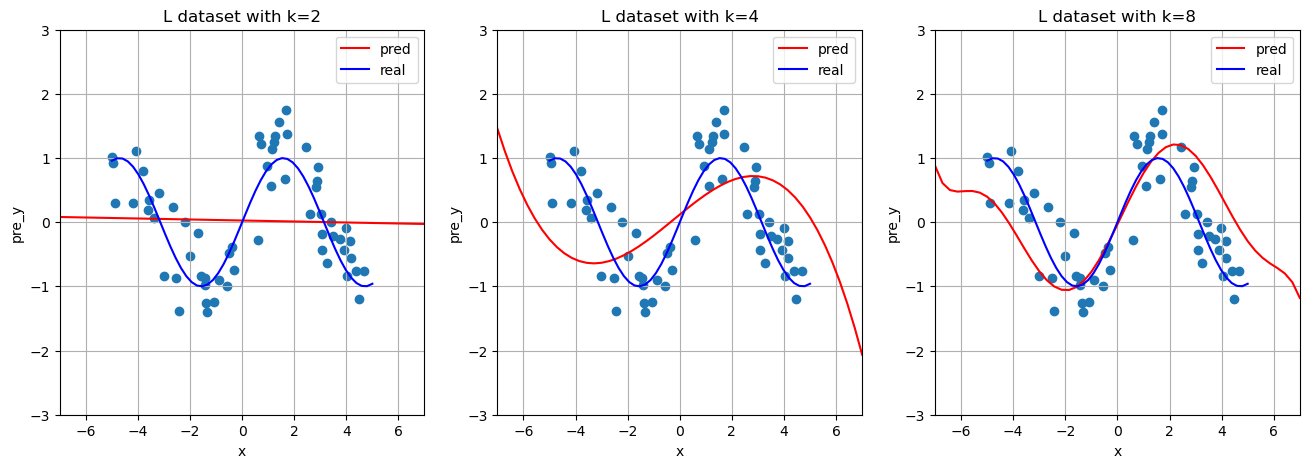

In [152]:
# 数据集 S，M 和 L
datasets = [[x_s, y_s], [x_m, y_m], [x_l, y_l]]
degrees = [2, 4, 8]
dataset_name= ['S','M','L']

i = 0  # 辅助变量

for x_list, y_list in datasets:
    plt.figure(figsize=(16, 5))

    # 对一个数据集，采用不同维度求w
    for degree in degrees:

        # 获得设计矩阵
        design_matrix = np.zeros(degree)
        for x in x_list:
            design_matrix = np.vstack((design_matrix, poly_vector(degree, x)))
        design_matrix = design_matrix[1:]

        # 获得Y等列向量
        y_matrix = y_list.reshape(-1,1)

        # 使用数学结论计算最佳的w向量
        w_best = np.linalg.inv(design_matrix.T @ design_matrix) @ design_matrix.T @ y_matrix

        # 得到预测函数
        pred_y = pre_f(degree, w_best)

        
        # 绘图
        plt.subplot(1,3,int(np.log2(degree)))
        
        x_real = np.linspace(-7,7)
        plt.xlim(-7,7)
        plt.ylim(-3,3)
        plt.plot(x_real, pred_y, label='pred', color='red')
        plt.plot(x_true, y_true, label = 'real', color='blue')
        plt.scatter(x_list, y_list)

        plt.xlabel('x')
        plt.ylabel('pre_y')
        plt.title('{} dataset with k={}'.format(dataset_name[i],degree))
        plt.grid(True)
        plt.legend()
    plt.show()

    i = i + 1
    


## 结果分析

### 1. 部分场景下的泛化性能差
    上图中，在数据集（-5，5）外容易严重偏离，这可能是有如下原因：
    1. 拟合的多项式线性函数过于复杂，导致泛化性能差
    2. 数据集S数据量过少，最大似然估计不适合数据集稀疏/少的情况
### 2. S数据集的拟合效果不如M、L数据集结果
    最大似然估计本身的局限性，应对数据稀疏性能不好，这可以依靠增加k（维数）解决，但这也可能导致泛化性能差的问题，因此在k的选择上应该做到均衡


# 第三部分 贝叶斯回归
用K=2, K=4, K=8 的模型，分别用Bayesian原理拟合S, M, L三个数据集。将9种不同拟合结果的图像绘制出来

In [153]:
# 定义多项式基函数
def polynomial_basis(x, k):
    basis = np.zeros((len(x), k))
    
    for i in range(k):
        basis[:, i] = x**i

    return basis


# 使用数学结论的贝叶斯线性回归
# 模型先验参数已人为规定
def bayesian_regression(X_after_design, Y, lam = 4, sig = 0.5):
    XTX = X_after_design.T @ X_after_design

    
    # w高斯分布的两个参数
    cov= np.linalg.inv((1/(sig**2)) * XTX + lam * np.identity(XTX.shape[0])) # 方差
    mean = (1/(sig**2)) * (cov @ X_after_design.T @ Y)  # 均值

    return mean, cov


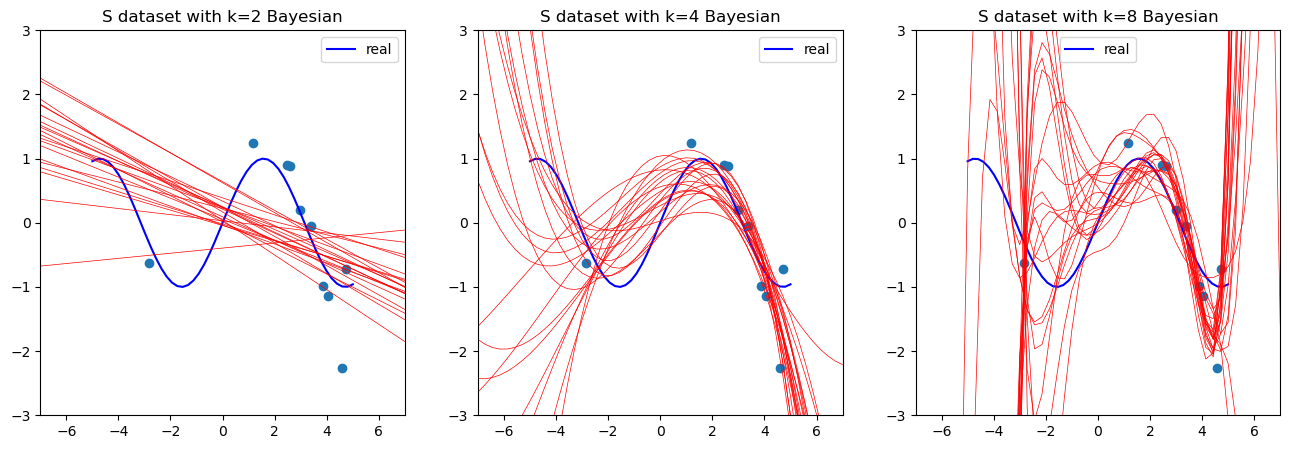

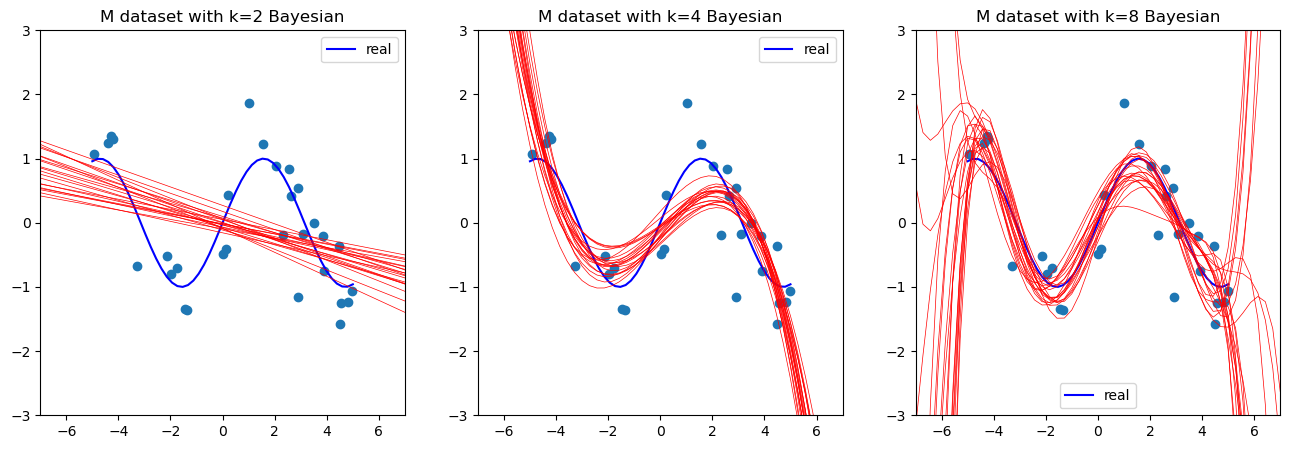

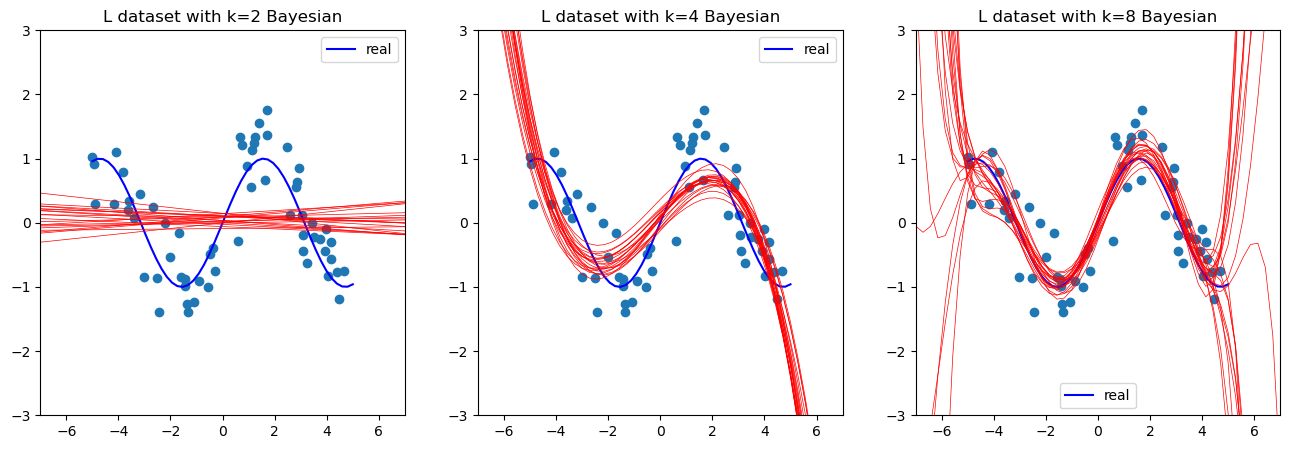

In [154]:
# 贝叶斯线性回归参数(事先规定，不修改不动默认值)
lam = 4
sig = 0.5

# 重申数据集 S，M 和 L
datasets = [[x_s, y_s], [x_m, y_m], [x_l, y_l]]
degrees = [2, 4, 8]
dataset_name= ['S','M','L']


# 前部分“获取特征矩阵”代码段的方法化
def get_design_matrix(degree, x_list):
    design_matrix = np.zeros(degree)
    for x in x_list:
        design_matrix = np.vstack((design_matrix, poly_vector(degree, x)))
    design_matrix = design_matrix[1:]

    return design_matrix


i = 0 # 辅助变量 

for x_list, y_list in datasets:
    plt.figure(figsize=(16, 5))

    for degree in degrees:
        x_design = get_design_matrix(degree, x_list)
        y_vec = y_list.reshape(-1,1)
        means, covs = bayesian_regression(x_design , y_vec) # 使用默认的回归参数

        # 开始绘图
        plt.subplot(1,3,int(np.log2(degree)))
        plt.xlim(-7,7)
        plt.ylim(-3,3)

        # 真实数据图
        plt.plot(x_true, y_true, label = 'real', color='blue')
        plt.scatter(x_list, y_list)
        
        x_real = np.linspace(-7,7)
        x_poly = polynomial_basis(x_real, degree)
        
        # 采样20个
        for j in range(20):
            sample_weights = np.random.multivariate_normal(means.flatten(), covs)
            y_pred = np.dot(x_poly, sample_weights) # 矩阵相乘得到函数
            plt.plot(x_real, y_pred, linewidth =0.5, color = 'red')
        
        plt.title('{} dataset with k={} Bayesian'.format(dataset_name[i],degree))
        plt.legend()
    
    plt.show()

    i = i + 1


## 结果分析
### 1. 泛化性能差
    和最大似然估计类似，可以显然观察到：模型复杂度升高（函数维数升高）无论对每个数据点还是真实函数曲线都能够带来更好的拟合能力，但是这样对数据集中稀疏部位、训练数据集之外的部分预测效果差。因此贝叶斯估计也不宜将预测函数设置的过于复杂

### 2. 数据数量对于训练效果的影响
    1. 同样和最大似然估计类似，数据集中拥有的数据越多，训练效果越好；
    2. 同时还可以观察到，数据越多的部分，贝叶斯估计的模型分布方差越小（线图越密集），对于模型也就越笃定。

### 3. 和极大似然估计的比较
    两者的预测模型具有一定程度上的重合度，极大似然估计和贝叶斯估计得到的函数曲线最密集处的形状基本相同，但是可以认为贝叶斯效果好于极大似然估计，因为：
    1. 数据稀疏情况下，贝叶斯仍然能够给出更加靠近真实函数的模型预测，尽管该模型不是所有模型中置信度最高的；
    2. 由于贝叶斯估计给出的是一组模型的概率分布，因此其更有能力覆盖更多的数据点（有能力反映更多的真实情况）；
    3. 同数据，同深度比较，贝叶斯估计给出的预测模=模型对真实曲线的覆盖面也更加优秀。
